A01367585 | Fabian Gonzalez Vera

# Librerias

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns

from mlxtend.evaluate import bias_variance_decomp
import warnings
warnings.filterwarnings('ignore') # Ignore pairplot warings

# ETL

In [2]:
cols = ['Sex','length','Diameter','Height','Whole_weight','Shucked_weight',
        'Viscera_weight','Shell_weight','Rings']
df = pd.read_csv('abalone/abalone.data',names=cols)
df = pd.get_dummies(df,columns=['Sex'],dtype='int') #Transform Sex into onehot encoding
df

,length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


In [3]:
df.isna().sum() # Check for null values

length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
Sex_F             0
Sex_I             0
Sex_M             0
dtype: int64

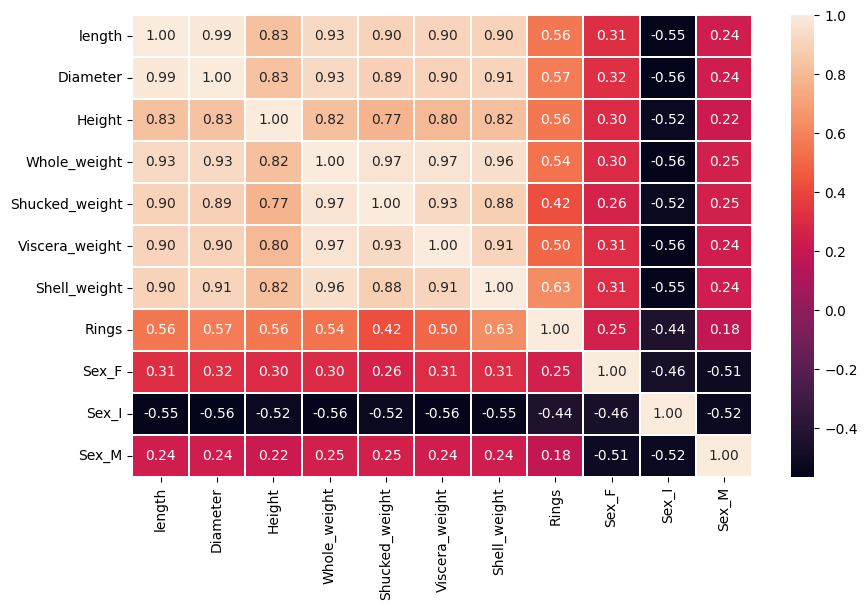

In [4]:
varsCorr = df.corr() #Cheack for correlation
plt.figure(figsize=(10,6))
sns.heatmap(varsCorr, annot=True, fmt='0.2f',linewidth=0.2)
plt.show()

In [5]:
newdf = df.copy()
newdf = newdf.sample(frac=1) #Shuffle the dataframe
newdf_x = newdf[['Sex_I','length','Diameter','Height','Whole_weight','Shell_weight']] #Select the chosen variables
newdf_y = newdf[['Rings']] #Target

train_x, test_x, train_y, test_y =  train_test_split(newdf_x, newdf_y, test_size=0.30)#split into 70 train 30 test


In [6]:
train_x

,Sex_I,length,Diameter,Height,Whole_weight,Shell_weight
1957,0,0.645,0.520,0.210,1.5535,0.4740
14,0,0.470,0.355,0.100,0.4755,0.1850
224,1,0.425,0.380,0.105,0.3265,0.1000
3060,0,0.630,0.515,0.175,1.1955,0.3700
866,0,0.605,0.455,0.160,1.1035,0.3250
...,...,...,...,...,...,...
3145,0,0.550,0.420,0.170,0.8465,0.2450
1703,0,0.640,0.505,0.165,1.2235,0.3600
3615,0,0.615,0.475,0.190,1.4335,0.3285
1611,0,0.550,0.435,0.140,0.7625,0.2590


In [7]:
train_y

,Rings
1957,16
14,10
224,10
3060,11
866,9
...,...
3145,13
1703,10
3615,9
1611,10


In [8]:
test_x

,Sex_I,length,Diameter,Height,Whole_weight,Shell_weight
1476,0,0.560,0.435,0.150,0.8715,0.1835
3922,1,0.525,0.400,0.140,0.6955,0.2530
3291,0,0.530,0.405,0.130,0.7380,0.1930
1660,0,0.600,0.470,0.165,1.0590,0.2750
3140,0,0.550,0.425,0.160,0.9700,0.4800
...,...,...,...,...,...,...
690,0,0.500,0.375,0.150,0.6360,0.1900
438,0,0.390,0.300,0.090,0.3055,0.0850
2630,1,0.355,0.285,0.095,0.2275,0.0715
3183,0,0.565,0.440,0.115,0.9185,0.2900


In [9]:
test_y

,Rings
1476,9
3922,10
3291,9
1660,9
3140,20
...,...
690,10
438,9
2630,6
3183,11


# Model with GridSearchCV

In [10]:
params = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid= params,
                           scoring= 'neg_root_mean_squared_error',
                           refit=True,
                           cv= RepeatedKFold(n_splits=5, n_repeats=3),
                           n_jobs=-1)
grid_search.fit(train_x, train_y)
print(grid_search.best_estimator_)

RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=9,
                      n_estimators=150)


In [11]:
print(grid_search.best_params_)

{'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 150}


In [12]:
grid_search.best_score_

-2.381587596417403

In [13]:
grid_search.scoring

'neg_root_mean_squared_error'

In [14]:
randForestReg = grid_search.best_estimator_
randForestReg

RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=9,
                      n_estimators=150)

In [15]:
y_preds = randForestReg.predict(test_x)
y_preds

array([ 9.70094043, 11.29888666,  9.95950415, ...,  7.41669584,
       11.34430198, 10.93827475])

In [16]:

print("tree score(RMSE): ", mean_squared_error(test_y, y_preds, squared=False))
print('R2 score with train data: ',randForestReg.score(train_x,train_y))
print('R2 score with test data: ',randForestReg.score(test_x,test_y))

tree score 2.3709863776638476
R2 score with train data:  0.491445736889657
R2 score with test data:  0.4455583113017776


In [17]:
# estimate bias and variance
mse, bias, var = bias_variance_decomp(randForestReg, train_x.values, train_y.values,
                                       test_x.values, test_y.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 14.338
Bias: 17787.266
Variance: 0.154


In [18]:
mean_squared_error(test_y, y_preds, squared=False)

2.3709863776638476

In [19]:
mean_squared_error(train_y, randForestReg.predict(train_x), squared=False)

2.3449867529118933

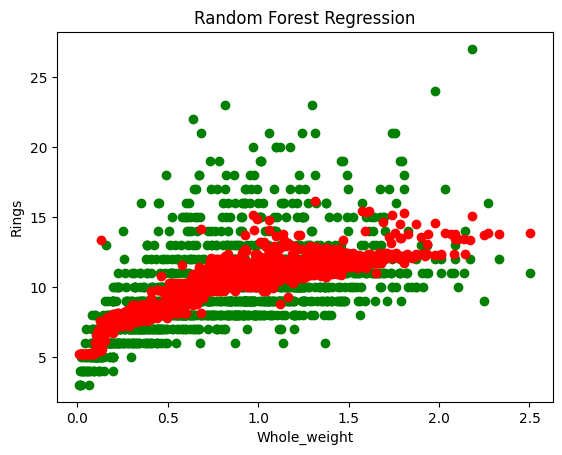

In [20]:
plt.scatter(test_x['Whole_weight'], test_y, color = 'green')
plt.scatter(test_x['Whole_weight'], y_preds, color = 'red')
plt.title('Random Forest Regression')
plt.xlabel('Whole_weight')
plt.ylabel('Rings')
plt.show() 

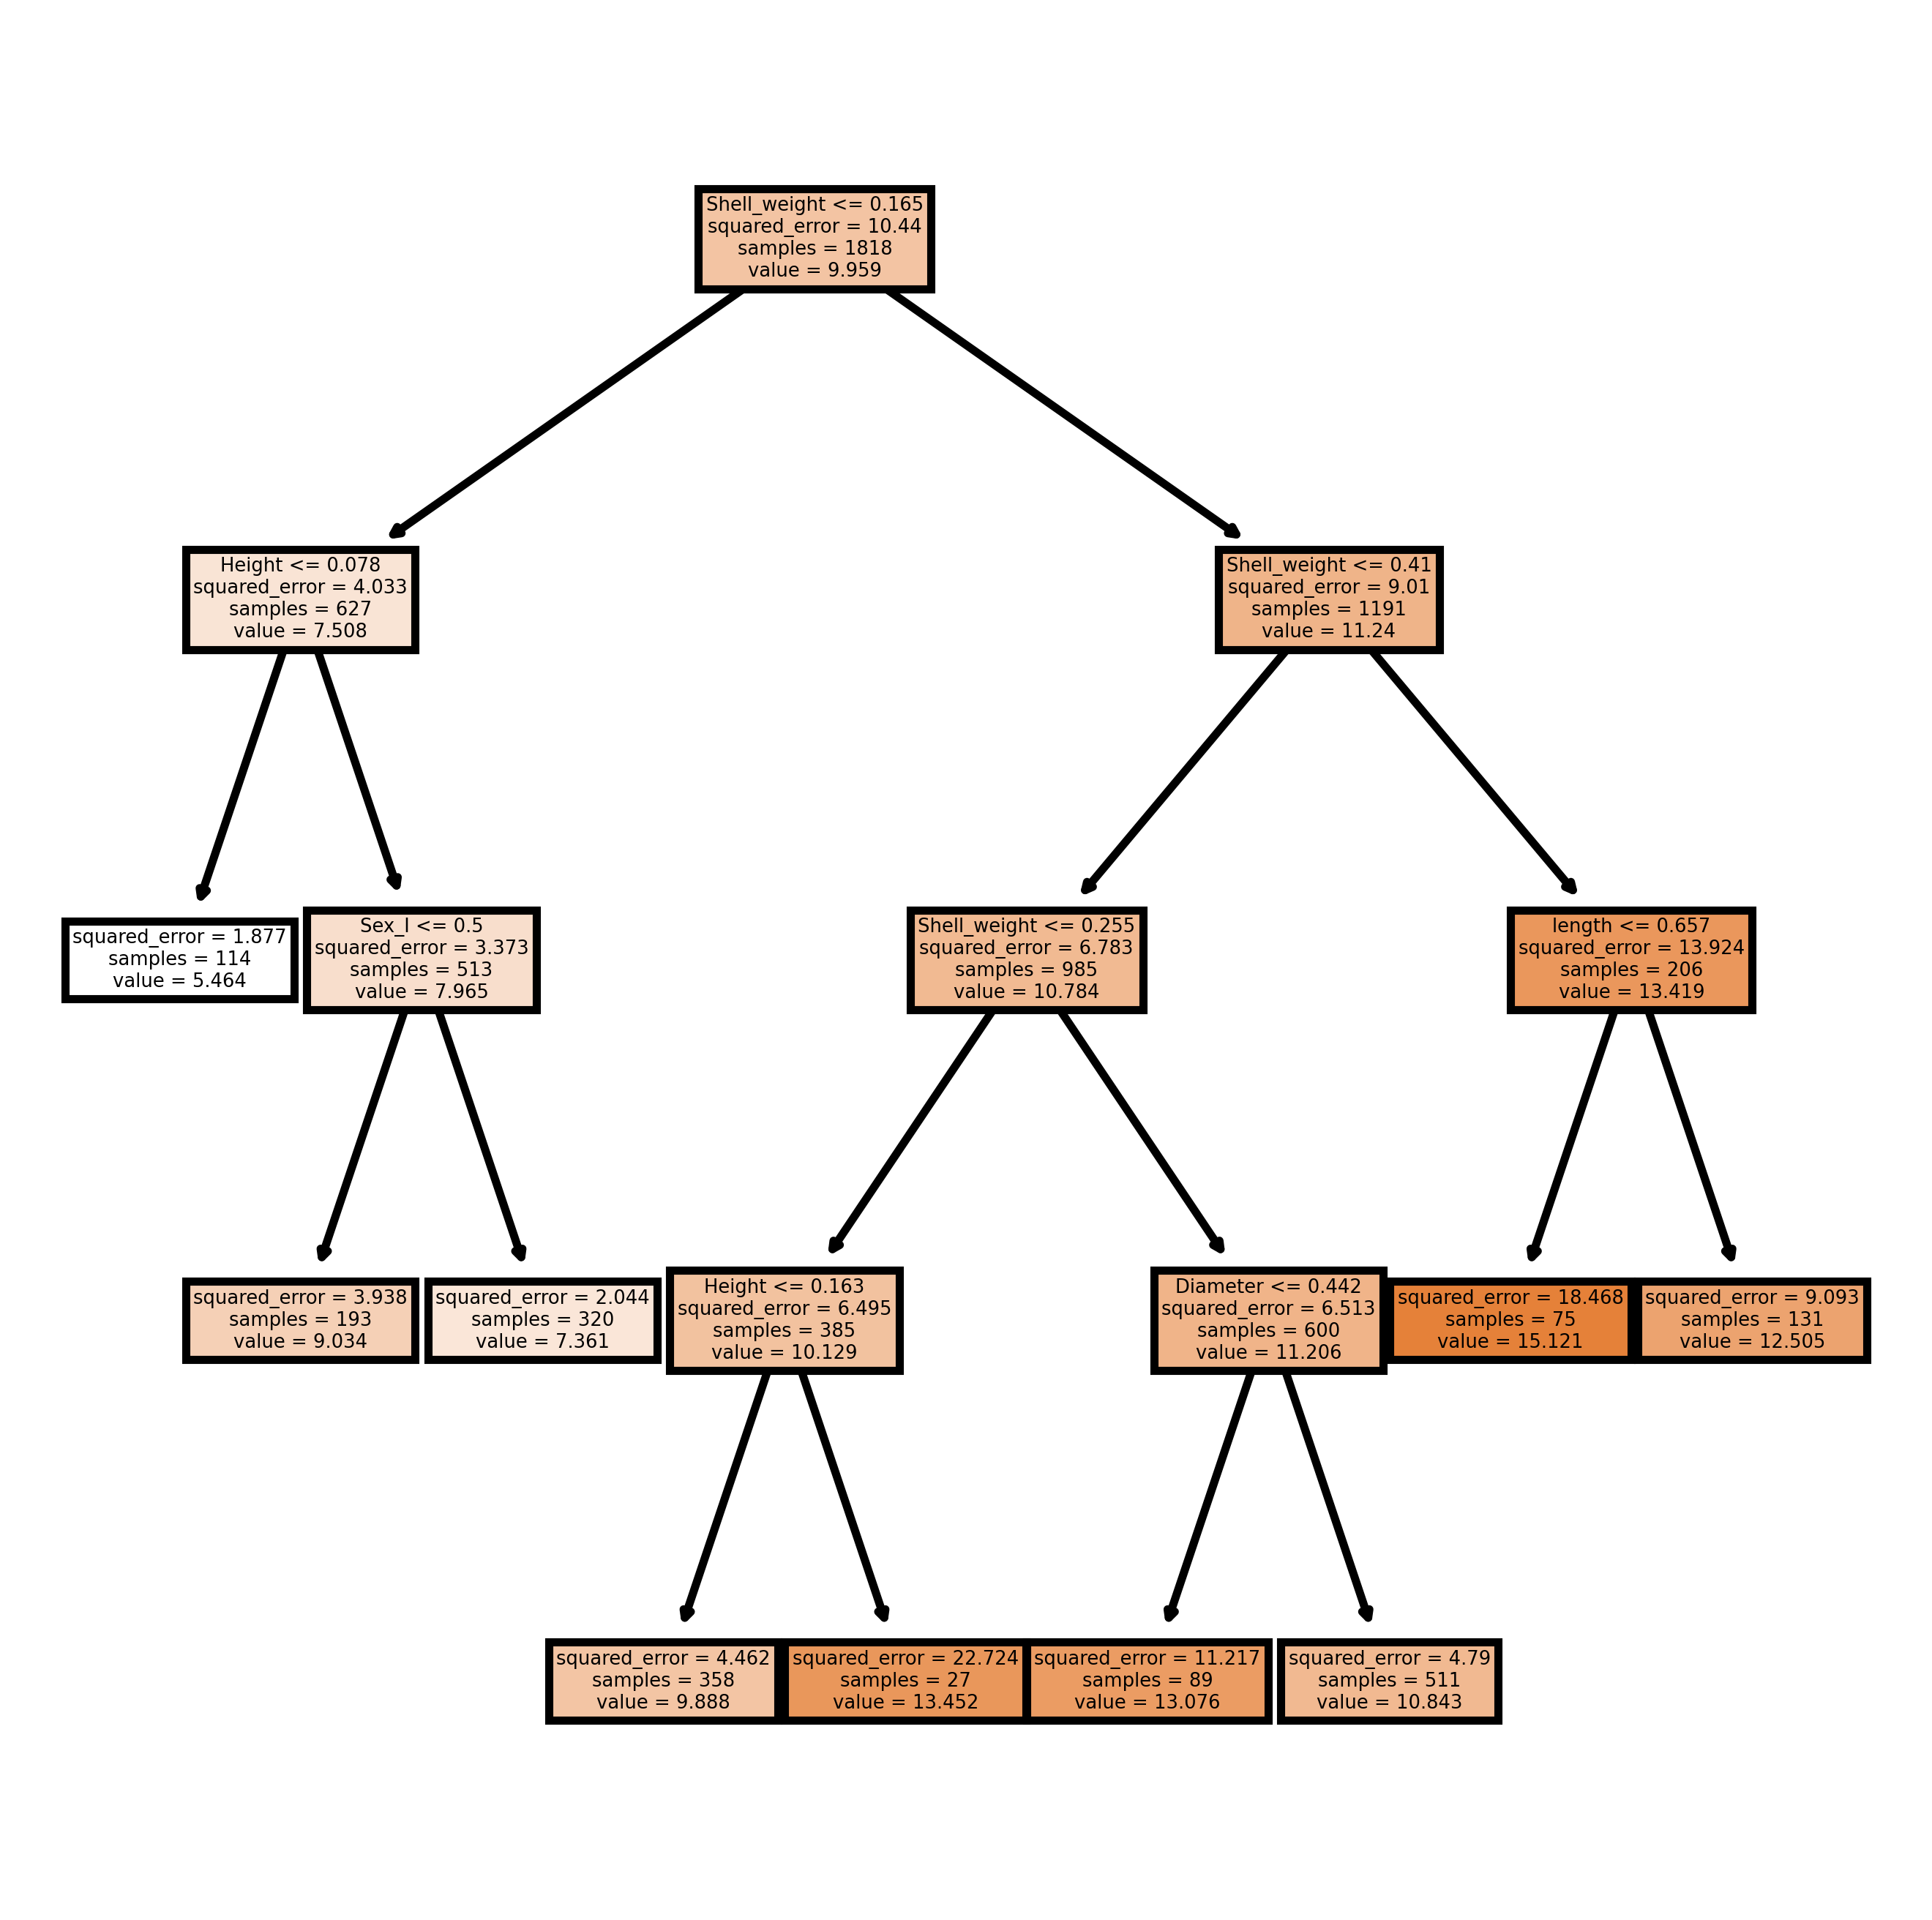

In [21]:
from sklearn import tree
fn=list(train_x.columns)
cn=list(train_y.columns)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(randForestReg.estimators_[0],
              feature_names = fn,
              class_names=cn,
              filled = True);
 